### Extract text from Pdf documents and apply NER

In [33]:
import pdfplumber, os
import os.path as osp
import pandas as pd
import numpy as np
from pathlib import Path
from pdf_extract.services import file
from pdf_extract.config import global_config as glob
from pdf_extract.config import config
from pdf_extract.utils import utils
from importlib import reload
import fasttext

reload(glob)
reload(config)
reload(utils);

In [2]:
list_of_NEG_docs = os.listdir(osp.join(glob.UC_DATA_DIR, 'example_cvs', 'negatives'))
n_neg = len(list_of_NEG_docs)

list_of_POS_docs = os.listdir(osp.join(glob.UC_DATA_DIR, 'example_cvs', 'positives'))
n_pos = len(list_of_POS_docs)

print(n_pos)
print(n_neg)


13
15


In [3]:
# fname = 'CV4'

# i, page_objects, text = 0, {}, []
# # The open method returns an instance of the pdfplumber.PDF class.
# with pdfplumber.open(osp.join(glob.UC_DATA_DIR, f"example_cvs/{fname}.pdf")) as pdf:
#     while i < len(pdf.pages):
#         page = pdf.pages[i]
#         page_objects[str(i+1)] = page.extract_text(x_tolerance=1).split('\n')
#         #mystring = page_objects[str(i+1)].replace('\r', '').replace('\n', '')
#         text += page_objects[str(i+1)]
#         print(f"Page {i}")
#         #print(page.extract_text())
#         i += 1


In [4]:
#page_objects['1']

Read in all Pdfs in directory:

Postives only:

In [5]:
raw_corpus1 = pd.DataFrame(columns=['text', 'fname'])

for z, fname in enumerate(list_of_POS_docs):
    i, page_objects, text = 0, {}, ""
    # The open method returns an instance of the pdfplumber.PDF class.
    with pdfplumber.open(osp.join(glob.UC_DATA_DIR, "example_cvs",f"positives/{fname}")) as pdf:
        while i < len(pdf.pages):
            page = pdf.pages[i]
            #print(pdf.metadata)
            page_objects[str(i+1)] = page.extract_text(x_tolerance=1, y_tolerance=3) #.split('\n')
            text += page_objects[str(i+1)]
            #print(f"Page {i}")
            #print(page.extract_text())
            i += 1
    
    raw_corpus1.loc[z] = [text,fname]  
raw_corpus1['label'] = 'positive'

Negatives only:

In [6]:
raw_corpus2 = pd.DataFrame(columns=['text', 'fname'])

for z, fname in enumerate(list_of_NEG_docs):
    i, page_objects, text = 0, {}, ""
    # The open method returns an instance of the pdfplumber.PDF class.
    with pdfplumber.open(osp.join(glob.UC_DATA_DIR, "example_cvs",f"negatives/{fname}")) as pdf:
        while i < len(pdf.pages):
            page = pdf.pages[i]
            page_objects[str(i+1)] = page.extract_text(x_tolerance=1, y_tolerance=3) #.split('\n')
            text += page_objects[str(i+1)]
            i += 1
    
    raw_corpus2.loc[z] = [text,fname]   
raw_corpus2['label'] = 'negative'

In [7]:
raw_corpus = pd.concat([raw_corpus1,raw_corpus2], axis=0, ignore_index=True)
#raw_corpus

In [8]:
#page_objects

#page.extract_words()

In [9]:
#page_instance = page_objects['1']

In [10]:
#pdf.metadata
#page_instance

Preprocess text corpus:

In [11]:
from pdf_extract.resources import preprocessor as preproc

reload(preproc)

# Preprocess corpus:
cleaner = preproc.clean_text(language='english', lemma = False, stem = False)

X_raw = raw_corpus['text'].copy()

# Full sample
X_cleaned = cleaner.fit_transform(X_raw)   

#X = raw_corpus['text']

#X_cl = cleaner.fit_transform(X_raw)

#docs = X_cl.tolist()    

Using english language.
Using 179 stop words.
Added 8 stopword(s).
Added 13 stopword(s).
Adding custom stop words...
Setting to lower cases.
Removing whitespaces.
Applying word tokenizer.
Removing custom stopwords.
Removing punctuations.
Removing numbers.
Removing digits.
Removing non-alphabetic characters.
Removing short tokens.
Finished preprocessing!


[nltk_data] Downloading package punkt to /home/alexv84/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexv84/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/alexv84/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexv84/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Prepare supervised FastText data set(s):

In [12]:
combine_fct = lambda x: '__label__{}'.format(x.label)

raw_corpus['text_cleaned'] = X_cleaned
raw_corpus['fasttext_label'] = raw_corpus.apply(combine_fct, axis = 1)

X = raw_corpus[['fasttext_label', 'text_cleaned']].reset_index(drop=True)   # keep label in X for txt-file below, will not be used directly in ft
#X.head()

In [13]:
from sklearn.model_selection import train_test_split

reload(utils)

X_train, X_valid, X_test, y_train, y_valid, y_test = utils.train_test_split_extend(X, X['fasttext_label'], test_size=[0.2, 0.2], random_state=42, shuffle=True)
#X_train, X_test, y_train, y_test = utils.train_test_split_extend(X, X['fasttext_label'], test_size=[0.2], random_state=42, shuffle=True)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)


(16, 2)
(6, 2)
(6, 2)


Prepare preprocessed data for fasttext training:

In [14]:
reload(file)

config_output = config.io['output']
Path(glob.UC_DATA_DIR).mkdir(parents=True, exist_ok=True)

# Train:
file.TXTService(verbose=True, root_path=glob.UC_DATA_DIR, **config_output['service']['TXTService1']).doWrite(X_train)

# Test:
file.TXTService(verbose=True, root_path=glob.UC_DATA_DIR, **config_output['service']['TXTService2']).doWrite(X_test)

# Dev:
file.TXTService(verbose=True, root_path=glob.UC_DATA_DIR, **config_output['service']['TXTService3']).doWrite(X_valid)

TXT Service output to file: /home/alexv84/Documents/Arbeit/Allianz/AZVers/data/train_data_fasttext.txt
TXT Service output to file: /home/alexv84/Documents/Arbeit/Allianz/AZVers/data/test_data_fasttext.txt
TXT Service output to file: /home/alexv84/Documents/Arbeit/Allianz/AZVers/data/dev_data_fasttext.txt


In [15]:
# Train model
#-------------

# Training word embeddings: 
#model = fasttext.train_supervised(input = os.path.join(glob.UC_DATA_DIR,'train_data_fasttext.txt'), wordNgrams = 2, dim=100, epoch=30, lr=1.0, verbose=2)

# Autotune hyperparameter:
model = fasttext.train_supervised(input=os.path.join(glob.UC_DATA_DIR,'train_data_fasttext.txt'), autotuneValidationFile=os.path.join(glob.UC_DATA_DIR,'dev_data_fasttext.txt'), dim=100, autotuneMetric="f1:__label__positive", autotuneDuration=300, verbose=2)


Progress: 100.0% Trials:  412 Best score:  1.000000 ETA:   0h 0m 0s
Training again with best arguments
Read 0M words
Number of words:  2295
Number of labels: 2
Progress: 100.0% words/sec/thread:   67693 lr:  0.000000 avg.loss:  0.693589 ETA:   0h 0m 0s


In [16]:
model.test(os.path.join(glob.UC_DATA_DIR,'dev_data_fasttext.txt'))

(6, 1.0, 1.0)

In [17]:
model.predict("I am a cook with 10 years of cooking experience. My hobbies are sports and cycling.")

(('__label__positive',), array([0.50001013]))

In [18]:
model.predict("I am a statistician from the university of Erlangen-Nuremberg")

(('__label__positive',), array([0.50001031]))

Get predictions for train/test set:

In [26]:
def predict(row):
    yhat, score = model.predict(row['text_cleaned'])
    return yhat[0]

def predict_proba(row):
    yhat, score = model.predict(row['text_cleaned'])
    return score[0]

y_train_pred = X_train.apply(predict,axis=1)
y_test_pred = X_test.apply(predict,axis=1)

y_train_score = X_train.apply(predict_proba, axis=1)
y_test_score = X_test.apply(predict_proba, axis=1)

In [20]:
from sklearn.metrics import classification_report

print('Train:')
print(classification_report(y_train, y_train_pred, target_names=['__label__negative', '__label__positive']))
print('Test:')
print(classification_report(y_test, y_test_pred, target_names=['__label__negative', '__label__positive']))

Train:
                   precision    recall  f1-score   support

__label__negative       0.90      1.00      0.95         9
__label__positive       1.00      0.86      0.92         7

         accuracy                           0.94        16
        macro avg       0.95      0.93      0.94        16
     weighted avg       0.94      0.94      0.94        16

Test:
                   precision    recall  f1-score   support

__label__negative       0.50      0.67      0.57         3
__label__positive       0.50      0.33      0.40         3

         accuracy                           0.50         6
        macro avg       0.50      0.50      0.49         6
     weighted avg       0.50      0.50      0.49         6



In [21]:
#page_instance.pdf.to_dict()

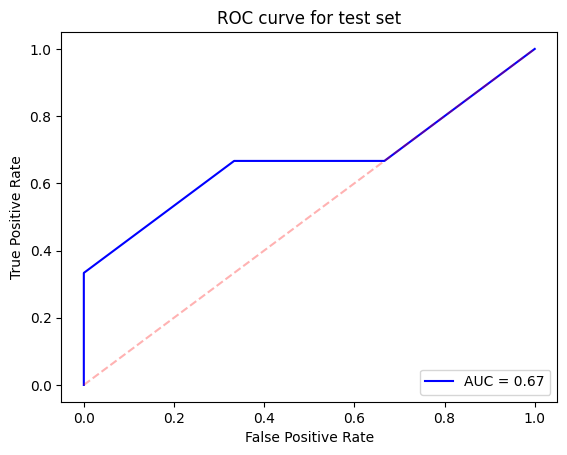

In [53]:
import sklearn.metrics as metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt

le = preprocessing.LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

#fpr, tpr, threshold = metrics.roc_curve(y_train_encoded, y_train_score)
fpr, tpr, threshold = metrics.roc_curve(y_test_encoded, y_test_score)

roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.title('ROC curve for test set')
plt.legend(loc=4)
plt.plot([0, 1], [0, 1],'r--', alpha=0.3)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Individually explain predictions on test set:

In [54]:
from lime.lime_text import LimeTextExplainer

class_names = ['negative', 'positive']

In [55]:
import numpy as np 
import webbrowser
from pathlib import Path

def fasttext_prediction_in_sklearn_format(classifier, texts):
    res = []
    # Ask FastText for the top 10 most likely labels for each piece of text.
    # This ensures we always get a probability score for every possible label in our model.
    labels, probabilities = classifier.predict(texts, k=10)

    # For each prediction, sort the probabaility scores into the same order
    # This is needed because FastText
    # returns predicitons sorted by most likely instead of in a fixed order.
    for label, probs, text in zip(labels, probabilities, texts):
        order = np.argsort(np.array(label))
        res.append(probs[order])

    return np.array(res)


# LIME needs to be able to mimic how the classifier splits
# the string into words. So we'll provide a function that
# mimics how FastText works.
def tokenize_string(string):
    return string.split()

In [59]:
# Create a LimeTextExplainer. This object knows how to explain a text-based
# prediction by dropping words randomly.
explainer = LimeTextExplainer(
    # We need to tell LIME how to split the string into words. We can do this
    # by giving it a function to call to split a string up the same way FastText does it.
    split_expression=tokenize_string,
    # Our FastText classifer uses bigrams (two-word pairs) to classify text. Setting
    # bow=False tells LIME to not assume that our classifier is based on single words only.
    bow=False,
    # To make the output pretty, tell LIME what to call each possible prediction from our model.
    class_names=class_names
)

sample_index = iter(range(X_test.shape[0]))

In [63]:
idx = next(sample_index)

# Make a prediction and explain it!
exp = explainer.explain_instance(
    X_test['text_cleaned'].iloc[idx],
    classifier_fn = lambda x: fasttext_prediction_in_sklearn_format(model, x),
    num_features=20, num_samples=5000, distance_metric='cosine'        # weight generated samples by proximity/similarity to query/test instance
)

#print(f"Document name: {X_test['fasttext_label'].iloc[idx]}")
print('Predicted: %s' % model.predict(X_test['text_cleaned'].iloc[idx])[0][0])
print('Probability("positive") =', model.predict(X_test['text_cleaned'].iloc[idx])[1][0])
print('True class: %s' % y_test.iloc[idx])


# Plot local token importances:
#-------------------------------
#%matplotlib inline
#fig = exp.as_pyplot_figure()

exp.show_in_notebook(text=True)

Predicted: __label__positive
Probability("positive") = 0.5000100135803223
True class: __label__negative


In [113]:
# Weighted features for linear surrogate model, which approximates the behaviour of the orig. classifier in the vicinity of the test example.
#exp.as_list()

### NER:

In [23]:
import spacy
from spacy import displacy

NER = spacy.load("en_core_web_lg")

Use pretrained language identification:

In [24]:
import fasttext

model = fasttext.load_model(osp.join(glob.UC_LANG_ID, 'lid.176.bin'))

label, score = model.predict("Hallo ich studiere Mathe in München", k=2)  # top 2 matching languages
label[0]


'__label__de'

In [25]:
i = 1
#raw_text = X.loc[i]
raw_text = X_cl.loc[i]
#raw_text

In [26]:
raw_text="The Indian Space Research Organisation or is the national space agency of India, headquartered in Bengaluru. It operates under Department of Space which is directly overseen by the Prime Minister of India while Chairman of ISRO acts as executive of DOS as well."

In [39]:
text1 = NER(raw_text)

In [40]:
# for word in text1.ents:
#     print(word.text,word.label_)

In [41]:
spacy.explain("ORG")

'Companies, agencies, institutions, etc.'

In [42]:
spacy.explain("GPE")

'Countries, cities, states'

In [44]:
#displacy.render(text1,style="ent",jupyter=True)

In [1]:
from bs4 import BeautifulSoup
import requests
import re

In [28]:
URL="https://www.zeebiz.com/markets/currency/news-cryptocurrency-news-today-june-12-bitcoin-dogecoin-shiba-inu-and-other-top-coins-prices-and-all-latest-updates-158490"

In [29]:
html_content = requests.get(URL).text

In [30]:
soup = BeautifulSoup(html_content, "lxml")

In [31]:
body=soup.body.text

In [32]:
body= body.replace('\n', ' ')
#body= body.replace('t', ' ')
#body= body.replace('r', ' ')
#body= body.replace('xa0', ' ')
#body=re.sub(r'[^ws]', '', body)

In [148]:
#body

In [149]:
text3= NER(body)